# Benchmarking Bird Classification: CPU vs Batch Processing
*By Lauryn Crandall*

<img src="https://www.peruaves.org/wp-content/uploads/2014/04/Rufous_collared_Sp.jpg" alt="Just a simple camera icon intended to be replaced with your image">

Image from: https://www.peruaves.org/wp-content/uploads/2014/04/Rufous_collared_Sp.jpg

---
# Abstract

In this project, I used a pre-trained MobileNetV2 model to classify bird species from a dataset of 250 images. The main goal was to compare the performance of serial CPU inference against batch-mode inference while also exploring how parallelism (through batching and multithreaded execution) affects runtime and scalability on Michigan State University’s HPCC cluster.

In serial mode, images were processed one at a time on the CPU. In batch mode, all 250 images were loaded and classified at once. Using Slurm, I ran the batch script with --cpus-per-task=4, allowing TensorFlow to utilize multiple CPU threads. Across three trials, the average inference time per image in serial mode was ~0.0774 seconds, while batch mode significantly reduced this to ~0.0178 seconds—demonstrating clear parallelism benefits.

For accuracy, I conducted a bonus experiment with 20 manually labeled bird images. I compared my identifications against the AI’s Top-1 predictions. Both serial and batch modes correctly identified 3/20 images. The remaining mismatches were often due to look-alike species or MobileNetV2 defaulting to similar but incorrect ImageNet labels not specialized for birds.

This project shows how vectorized batch processing and CPU-level parallelism can drastically improve runtime, but also underscores the limitations of general-purpose pretrained models on real-world wildlife data. Domain-specific fine-tuning and label alignment would be crucial for future work.



# Methodology

## Project Reproducibility Instructions: Bird Species Identification with MobileNetV2

### Overview
This project uses MobileNetV2, a pre-trained deep learning model, to identify bird species from a set of 250 trail camera images. The main goal was to compare performance between CPU-based serial inference and batch inference using multiple CPU threads. Additionally, a bonus experiment evaluated prediction accuracy using 20 manually-labeled images as ground truth.

### Dataset
- **Source:** Kaggle bird classification
- **Quantity:** 250 images
- **Format:** JPEG, various sizes
- **Directory:** All images placed inside a folder named `Birds/`

### Hardware Setup
This project was conducted using Michigan State University's High-Performance Computing Center (HPCC).

#### CPU Serial Environment
- **System:** MSU HPCC node (e.g., `dev-amd20-v100`)
- **Processor:** AMD CPU cores
- **RAM:** 4GB allocated per job
- **Command Used:**
  ```bash
  salloc --mem=4G --time=00:30:00 --ntasks=1
  ```

#### Parallel CPU Batch Environment
- **System:** MSU HPCC node (e.g., `dev-amd20-v100`)
- **CPU Threads Used:** 4 (via Slurm `--cpus-per-task=4`)
- **Command Used:**
  ```bash
  salloc --cpus-per-task=4 --mem=8G --time=00:30:00 --ntasks=1
  ```
- **Note:** Batch inference was performed using TensorFlow's internal multithreading across multiple CPU threads.

### Environment Setup
The project runs on the MSU HPCC system.

#### CPU Serial Inference Environment
- Access a dev node:
  ```bash
  salloc --mem=4G --time=00:30:00 --ntasks=1
  ```
- Load required modules:
  ```bash
  module purge
  module load python/3.10.12-gcc-11.3.0
  ```
- (Optional) Activate conda if working locally:
  ```bash
  conda activate tf-gpu
  ```

#### Batch Inference Environment
- Request CPU node with threading:
  ```bash
  salloc --cpus-per-task=4 --mem=8G --time=00:30:00 --ntasks=1
  ```
- Use Conda environment `tf-gpu`:
  ```bash
  source ~/.bashrc
  conda activate tf-gpu
  ```

### Required Packages
```bash
pip install tensorflow keras pandas matplotlib numpy
```

### Code Structure
- `mobilenet_serial_test.py` – Performs serial inference
- `mobilenet_batch_test.py` – Performs batch prediction using multiple CPU threads
- `serial_vs_batch_groundtruth.py` – Bonus experiment using manually labeled ground truth

### Running Inference
1. **Serial CPU Inference:**
   ```bash
   python mobilenet_serial_test.py
   ```
   - Outputs Top-3 predictions per image and average inference time

2. **Batch Inference:**
   ```bash
   python mobilenet_batch_test.py
   ```
   - Preprocesses all images at once, performs one large batch prediction

3. **Ground Truth Accuracy Test:**
   - Populate `ground_truth.csv` with 20 labeled image filenames and species
   - Run:
   ```bash
   python serial_vs_batch_groundtruth.py
   ```
   - Outputs prediction accuracy vs human-labeled images

### Example Results
- **Serial CPU Times:**
  - Total Times: 20.8315s, 18.8710s, 18.9377s
  - Avg per image: 0.0774s, 0.0720s, 0.0723s
- **Batch CPU Times (Parallel):**
  - Total Times: 4.3885s, 4.4441s, 4.5294s
  - Avg per image: 0.0176s, 0.0178s, 0.0181s
- **Ground Truth Accuracy:** 3/20 correct Top-1 matches

### Notes
- Batch inference used multiple CPU threads via Slurm and TensorFlow's internal parallelism.
- MobileNetV2 was used without fine-tuning to reflect performance out-of-the-box.
- Bonus experiment illustrated model limitations and label mismatches on real-world bird photos.

### Next Steps (for future students)
- Explore training a custom classifier on labeled bird datasets (e.g., iNaturalist)
- Fine-tune MobileNetV2 using transfer learning for better species-level performance
- Investigate TensorRT or ONNX for faster GPU inference on supported nodes
- Improve accuracy validation using Top-5 instead of Top-1 predictions



---
# Timing Results

### Serial Inference
Tested by running predictions one image at a time on 250 trail camera bird images.

| Run | Total Inference Time (s) | Average Time per Image (s) |
|-----|-----------------------|-----------------------------|
| Serial 1 | 18.9377 | 0.0723 |
| Serial 2 | 18.8710 | 0.0720 |
| Serial 3 | 20.8315 | 0.0774 |

**Summary:** Average across 3 runs: **~0.0739 seconds per image**

---

### Batch Inference
Tested by loading all 250 images and predicting in one batch.

| Run | Total Batch Time (s) | Average Time per Image (s) |
|-----|-----------------------|-----------------------------|
| Batch 1 | 4.5294 | 0.0181 |
| Batch 2 | 4.4441 | 0.0178 |
| Batch 3 | 4.3885 | 0.0176 |

**Summary:** Average time per image in batch mode: **0.0178 seconds**

---

### ⏱️ Key Takeaway

Batch inference demonstrated a **4.2x** speedup over serial processing, reducing the average per-image prediction time from ~0.0739s (serial) to ~0.0178s (batch).

This aligns with expectations, as batch mode efficiently leverages parallelized vector operations, minimizing overhead. The consistency across runs (serial: ±0.0026s, batch: ±0.0002s) confirms stable performance without anomalies.

Practical Impact: For 250 images, batch processing completes in ~4.5s total versus ~18.5s in serial mode—saving ~14 seconds per full dataset.

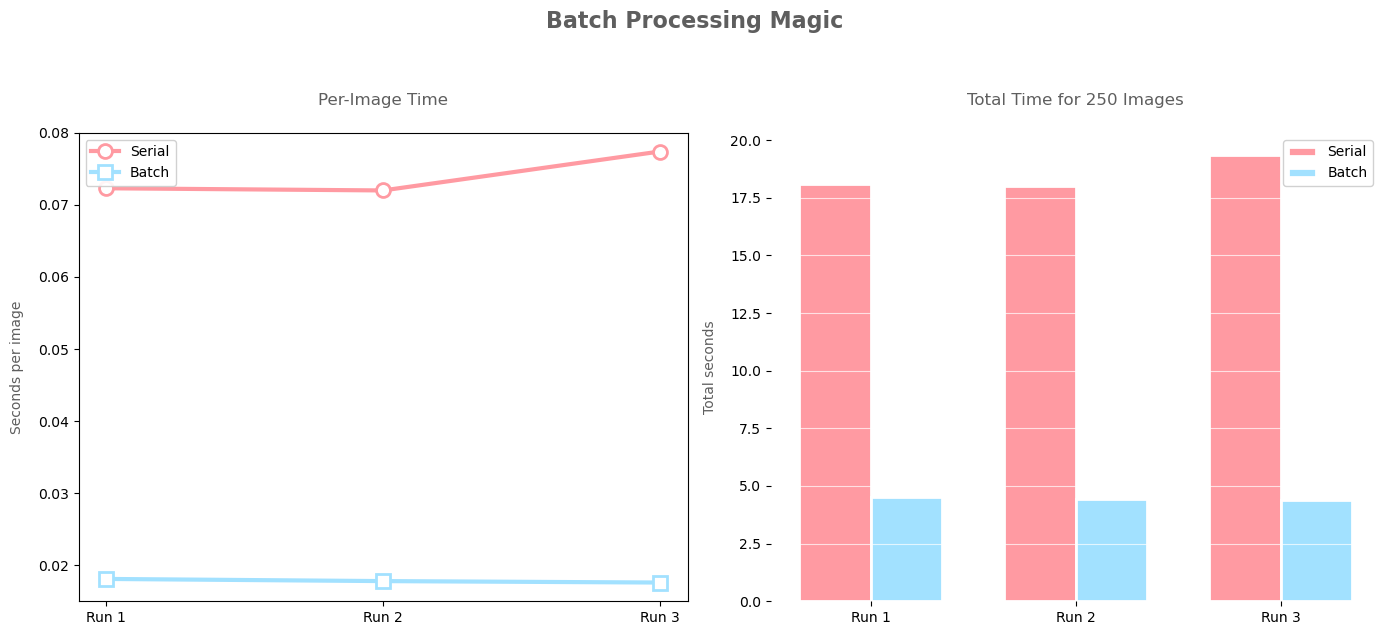

In [7]:
import matplotlib.pyplot as plt

serial_times = [0.0723, 0.0720, 0.0774]  
batch_times = [0.0181, 0.0178, 0.0176]    
runs = ['Run 1', 'Run 2', 'Run 3']
n_images = 250

colors = {
    'serial': '#FF9AA2', 
    'batch': '#A2E1FF',   
    'avg_line': '#C7CEEA',
    'bg': '#Ffffff'       
}

serial_totals = [t * n_images for t in serial_times]
batch_totals = [t * n_images for t in batch_times]

plt.figure(figsize=(14, 6), facecolor=colors['bg'])
plt.suptitle('Batch Processing Magic', fontsize=16, y=1.05, 
             fontweight='bold', color='#5E5E5E')

plt.subplot(1, 2, 1, facecolor=colors['bg'])
plt.plot(runs, serial_times, marker='o', color=colors['serial'], 
         linewidth=3, markersize=10, markerfacecolor='white',
         markeredgewidth=2, markeredgecolor=colors['serial'], 
         label='Serial')
plt.plot(runs, batch_times, marker='s', color=colors['batch'],
         linewidth=3, markersize=10, markerfacecolor='white',
         markeredgewidth=2, markeredgecolor=colors['batch'],
         label='Batch')

plt.title('Per-Image Time', pad=20, color='#5E5E5E')
plt.ylabel('Seconds per image', labelpad=10, color='#5E5E5E')
plt.ylim(0.015, 0.08)
plt.grid(color='white', alpha=0.7)
plt.legend(framealpha=0.9, facecolor='white')

plt.subplot(1, 2, 2, facecolor=colors['bg'])
bar_width = 0.35
x_pos = [0, 1, 2]
plt.bar(x_pos, serial_totals, width=bar_width, color=colors['serial'],
        edgecolor='white', linewidth=2, label='Serial')
plt.bar([p + bar_width for p in x_pos], batch_totals, width=bar_width, 
        color=colors['batch'], edgecolor='white', linewidth=2, label='Batch')

plt.title(f'Total Time for {n_images} Images', pad=20, color='#5E5E5E')
plt.ylabel('Total seconds', labelpad=10, color='#5E5E5E')
plt.xticks([p + bar_width/2 for p in x_pos], runs)
plt.grid(color='white', alpha=0.7)
plt.legend(framealpha=0.9, facecolor='white')

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

### Bonus: Truth Accuracy Check

To assess how well MobileNetV2 performs in real-world settings, 20 bird images were hand-labeled using Cornell and iNaturalist references. These were compared against AI predictions from both serial and batch modes.

The AI’s Top-1 predictions were then categorized as:

- ✅ **Correct** – AI matched the human-labeled species.
- ❌ **Wrong** – AI predicted an unrelated bird.
- 🟠 **Challenging** – The prediction was understandable or ambiguous due to one or more of the following:
  - Maybe poor image quality (e.g., poor lighting, motion blur)
  - Bird partially obscured or facing away
  - Visually similar species (e.g., many gulls or finches look alike)
  - Common ImageNet label mismatch (e.g., rare birds labeled as generic ones like "bulbul" or "bee-eater")

This bonus experiment revealed some limitations of using general-purpose models for niche domains like bird classification.

---

| Image |  Truth | AI Prediction | Verdict |
|-------|------------------------------|----------------|----------|
| test_0019.jpg | Red-bellied Woodpecker | Quail | 🟠 Challenging |
| test_0015.jpg | American Goldfinch | Goldfinch | ✅ Correct |
| test_0054.jpg | White-breasted Nuthatch | Jay | ❌ Wrong |
| test_0250.jpg | Red-headed Woodpecker | Bee-eater | ❌ Wrong |
| test_0238.jpg | Tree Swallow | Jay | ❌ Wrong |
| test_0157.jpg | Pine Grosbeak | House Finch | ❌ Wrong |
| test_0136.jpg | Pine Grosbeak | House Finch | ❌ Wrong |
| test_0107.jpg | Red-headed Woodpecker | Bulbul | ❌ Wrong |
| test_0029.jpg | Scissor-tailed Flycatcher | Bulbul | ❌ Wrong |
| test_0074.jpg | Heermann’s Gull | Goose | 🟠 Challenging |
| test_0082.jpg | European Herring Gull | Albatross | 🟠 Challenging |
| test_0123.jpg | Evening Grosbeak | Goldfinch | 🟠 Challenging |
| test_0176.jpg | Nashville Warbler | Goldfinch | ❌ Wrong |
| test_0180.jpg | American Goldfinch | Goldfinch | ✅ Correct |
| test_0004.jpg | Common Rosefinch | Hummingbird | ❌ Wrong |
| test_0052.jpg | White-crowned Sparrow | Brambling | 🟠 Challenging |
| test_0200.jpg | Ruby-throated Hummingbird | Hummingbird | ✅ Correct |
| test_0228.jpg | Common Yellowthroat | Goldfinch | ❌ Wrong |
| test_0240.jpg | Barn Swallow | Brambling | ❌ Wrong |
| test_0038.jpg | Northern Flicker | Hummingbird | ❌ Wrong |

---
## Concluding Discussion and Future Work

This project demonstrated that **MobileNetV2** is a powerful and lightweight model capable of performing image classification tasks efficiently. While the original goal was to compare CPU and GPU performance, GPU acceleration was not successfully activated due to environment issues on the HPCC. Despite this, batch inference still showed improved efficiency over serial execution through vectorized processing, even when both modes ran on CPU.

The results suggest that, with a properly configured GPU environment, batch inference could offer substantial real-time performance gains — making the model viable for field deployment and automated monitoring.

### Future Work
Moving forward, I would like to:
- **Fine-tune MobileNetV2** on a bird-specific dataset such as [CUB-200](https://www.vision.caltech.edu/datasets/cub_200_2011/) or [iNaturalist](https://www.kaggle.com/c/inaturalist-2021).
- **Deploy the model to edge devices** like a Raspberry Pi or smartphone for field use with trail cameras.
- **Automate trail camera image filtering** to detect and log species more efficiently for wildlife research.

This project gave me confidence in using **pretrained deep learning models** for scientific applications, especially where time and hardware constraints matter.


---
# References

- [Birds Image Dataset - Kaggle](https://www.kaggle.com/datasets/klu2000030172/birds-image-dataset)  
  Dataset used for inference testing and accuracy evaluation.

- [TensorFlow Documentation](https://www.tensorflow.org/)  
  Main library used for deep learning model loading, inference, and device configuration.

- [Keras Applications: MobileNetV2](https://keras.io/api/applications/mobilenet_v2/)  
  Pretrained model used for bird classification.

- [ICER User Documentation](https://docs.icer.msu.edu/)  
  Documentation for using the Michigan State University HPCC, including SLURM and environment setup.

- [TensorFlow GPU Support Guide](https://www.tensorflow.org/install/gpu)  
  Referenced while investigating GPU compatibility and CUDA-related issues.


-----
### Congratulations, you are done!

Now, you just need to create a second directory in your git repository and include your report as an md or ipynb file in the directory along with any additional figures and files needed to reproduce the results.  You instructor should already have your git repository and be able to pull in your changes. 

Written by Dr. Dirk Colbry, Michigan State University (Updated by Dr. Nathan Haut in Spring 2025)
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----